# Chlorophyll Map Files

This notebook generates the source GeoTiff files used by Nilas from the provided netcdf files from OCCCI.

Data is transformed from EPSG 4326 (Web Mercator) to EPSG 3976 (South Polar Stereo)

In [1]:
#directory paths
_work_dir='/g/data/gv90/as2285/miz/'
_data_dir='/g/data/gv90/P6_data/'

In [2]:
#some constants
CLIMAT_DATES=[1998,2020]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo
import odc.geo.geobox
import odc.geo.xr
from datacube.utils.cog import write_cog

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology



In [5]:
%run {_work_dir}utils/plot_tools.ipynb

# The Dataset

In [6]:
from os import listdir
file_names = listdir(f'{_data_dir}OCCCIv6.0/')
files = [f'{_data_dir}OCCCIv6.0/{iFile}' for iFile in file_names]

In [7]:
big_chlor_da=xr.open_mfdataset(files).chlor_a

In [8]:
big_chlor_da

<xarray.DataArray 'chlor_a' (time: 304, lat: 4320, lon: 8640)>
dask.array<concatenate, shape=(304, 4320, 8640), dtype=float32, chunksize=(1, 4320, 8640), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2022-12-01
Attributes:
    ancillary_variables:  chlor_a_log10_rmsd chlor_a_log10_bias
    long_name:            Chlorophyll-a concentration in seawater (not log-tr...
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass_concentration_of_chlorophyll_a_in_sea_water
    units:                milligram m-3
    units_nonstandard:    mg m^-3

In [9]:
climat_chlor_ds=climatology(big_chlor_da, CLIMAT_DATES)

In [10]:
anoms_da=big_chlor_da.groupby('time.month')-climat_chlor_ds.ave

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


# Set bounds

In [11]:
src_geobox=odc.geo.geobox.GeoBox.from_bbox(
    [-180,-90,180,90],
    "epsg:4326",
    shape=[4320,8640]
    )

In [12]:
map_geobox = odc.geo.geobox.GeoBox.from_bbox(
    [-4500000,-4500000,4500000,4500000],
    "epsg:3976",
    resolution=10000
    )

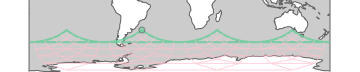

In [13]:
map_geobox

In [14]:
map_geobox.extent.exterior.to_crs("epsg:4326").points[:3]

[(-45.0, -35.58352463367147),
 (-135.0, -35.58352463367147),
 (135.0, -35.58352463367147)]

In [15]:
newNd = np.ndarray([900,900])

# cogs for tracker

In [16]:
#start in 2022 because we've run the previos years already, there is only new data for 2022
START_YEAR='2022'

In [17]:
datetimes_xr=big_chlor_da.sel(time=slice(START_YEAR,'2050')).time

Transform and save the concentrations:

In [18]:
for iTime in datetimes_xr:
    odc.geo.xr.rio_reproject(
        big_chlor_da.sel(time=iTime, drop=True).values,
        newNd,
        src_geobox,
        map_geobox,
        'bilinear',
        src_nodata=np.nan
    )

    new_xr=odc.geo.xr.wrap_xr(
        newNd,
        map_geobox
    )

    write_cog(
        new_xr,
        f'{_data_dir}tracker_data/chlor_conc_cog/chlor_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True
    )

And the anomalies:

In [19]:
for iTime in datetimes_xr:
    odc.geo.xr.rio_reproject(
        anoms_da.sel(time=iTime, drop=True).values,
        newNd,
        src_geobox,
        map_geobox,
        'bilinear',
        src_nodata=np.nan
    )

    new_xr=odc.geo.xr.wrap_xr(
        newNd,
        map_geobox
    )

    write_cog(
        new_xr,
        f'{_data_dir}tracker_data/chlor_conc_anoms_cog/chlor_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True
    )